# Pandemic Prediction Using Graph Neural Networks
### Royston Rex Fernandez

# Import Libraries

In [2]:
# ========== Standard Library Imports ==========
import os  # For interacting with the operating system (file handling)
import os.path as osp  # For working with file paths conveniently
import glob  # For retrieving files by matching patterns
import warnings  # To control the display of warning messages
import time  # To measure execution time

# ========== Third-Party Libraries ==========
import pandas as pd  # For data manipulation and analysis 
import dask.dataframe as dd  # For parallel computing with large datasets
from geopy.distance import geodesic  # For calculating geographic distances
from sklearn.preprocessing import StandardScaler  # For standardising dataset features
import matplotlib.pyplot as plt  # For data visualisation
import seaborn as sns  # For statistical data visualisation
import networkx as nx  # For creating and visualising network graphs
import numpy as np  # For numerical computations
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For performance metrics

# ========== PyTorch and PyTorch Geometric Imports ==========
import torch  # Core PyTorch library for tensor operations and neural networks
import torch.nn as nn  # For creating neural network layers and architectures
import torch.optim as optim  # For optimisers (AdamW)
import torch_geometric  # For graph neural network implementations in PyTorch
from torch_geometric.data import Data, Batch  # For handling graph data
from torch_geometric.loader import DataLoader  # For batching and loading graph datasets
from torch_geometric.nn import GCNConv, BatchNorm  # GCN layer and BatchNorm for graph neural networks
import torch.nn.functional as F  # For common functions such as ReLU, softmax, etc.

# ========== Custom Configurations ==========
# Set custom Seaborn theme for visualisation aesthetics
custom = {
    'xtick.bottom': True,
    'ytick.left': True,
    'grid.color': 'gray',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor': 'gray'
}
sns.set_theme(style='darkgrid', rc=custom)

# ========== Suppress Warnings ==========
warnings.filterwarnings("ignore")  # To hide unnecessary warnings during execution


# Data Processing
## Moblity Data

In [103]:
# Define the path to your CSV files
path_to_csv_files = r'D:\UoL\MSc Project\Dataset\Mobility Data\data\*.csv'

# Path to your CSV files
csv_files = glob.glob(path_to_csv_files)

# Read all CSV files into a Dask dataframe
ddf = dd.read_csv(csv_files, assume_missing=True, dtype={'date': 'object'})

# Clean the column names
ddf.columns = ddf.columns.str.strip()

# Convert the 'date' column to datetime format
ddf['date'] = dd.to_datetime(ddf['date'], format='%Y-%m-%d', errors='raise')

# Rename columns
ddf = ddf.rename(columns={
    'geoid_o': 'source',
    'geoid_d': 'target'
})

# Filter rows for flows more than 100
ddf = ddf[ddf['visitor_flows'] > 100]
# Drop rows where source and target are the same
ddf = ddf[ddf['source'] != ddf['target']]

# Define a function to calculate distance using geopy
def compute_distance(lat_o, lng_o, lat_d, lng_d):
    return geodesic((lat_o, lng_o), (lat_d, lng_d)).kilometers

# Filter rows with valid coordinates
ddf = ddf.dropna(subset=['lat_o', 'lng_o', 'lat_d', 'lng_d'])

# Apply the vectorised distance calculation to each row in the DataFrame
ddf['distance_km'] = ddf.apply(
    lambda row: compute_distance(row['lat_o'], row['lng_o'], row['lat_d'], row['lng_d']),
    axis=1,
    meta=('x', 'f8')
)

ddf = ddf.drop(columns=['lng_o', 'lng_d', 'lat_d', 'lat_o','pop_flows'])

ddf

,source,target,date,visitor_flows,distance_km
npartitions=450,,,,,
,float64,float64,datetime64[ns],float64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [ ]:
# Save Dask DataFrame to HDF5
ddf.to_hdf(r'D:\UoL\MSc Project\Dataset\Mobility Data\mobility_data.h5', key='data', mode='w')

In [3]:
# Read the HDF5 file into a Pandas DataFrame
mobility_data = pd.read_hdf(r'D:\UoL\MSc Project\Dataset\Mobility Data\mobility_data.h5', key='data')

In [4]:
# Setting the date column as index
mobility_data.set_index('date', inplace=True)
# Initialize the StandardScaler
scaler = StandardScaler()
# Columns to normalise
columns = ['visitor_flows', 'distance_km']
# Apply normalization only to selected columns
mobility_data[columns] = scaler.fit_transform(mobility_data[columns])

mobility_data.head()

,source,target,visitor_flows,distance_km
date,,,,
2020-01-22,1001.0,1021.0,-0.268472,-0.300365
2020-01-22,1001.0,1047.0,-0.346311,-0.255886
2020-01-22,1001.0,1051.0,1.019770,-0.263945
2020-01-22,1001.0,1073.0,-0.348257,-0.045135
2020-01-22,1001.0,1101.0,1.809840,-0.241819


## Infection Data

In [ ]:
# Load the confirmed data
confirmed_data_raw = pd.read_csv(r'D:\UoL\MSc Project\Dataset\Infection Data\time_series_covid19_confirmed_US.csv')
# Dropping unwanted columns from confirmed data
confirmed_data=confirmed_data_raw.drop(columns=['iso2', 'iso3', 'code3', 'Province_State', 'Country_Region', 'Combined_Key', 'Lat', 'Long_'])

# Load the death data
death_data_raw = pd.read_csv(r'D:\UoL\MSc Project\Dataset\Infection Data\time_series_covid19_deaths_US.csv')
# Dropping unwanted columns from confirmed data
death_data = death_data_raw.drop(columns=['iso2', 'iso3', 'code3', 'Province_State', 'Country_Region','Combined_Key', 'Lat', 'Long_'])


In [ ]:
# Strip whitespace if any
confirmed_data.columns = confirmed_data.columns.str.strip()
death_data.columns = death_data.columns.str.strip()

# Identify the columns that are not dates
id_vars = ['UID','FIPS', 'Admin2']

# Converting dates to right format
def convert_date_format(column_name):
    try:
        # Check if the column name is in dd/mm/yy format
        date_obj = pd.to_datetime(column_name, format='%d/%m/%y', errors='raise')
        # Convert to mm/dd/yy format
        return date_obj.strftime('%#m/%d/%y')
    except ValueError:
        # Return the column name unchanged if it doesn't match known formats
        return column_name

# Identify the columns that need conversion (1st to 12th of each month)
columns_to_convert = [col for col in confirmed_data.columns if col not in id_vars and col[0:2] in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']]

# Convert column names for confirmed_data
converted_columns = []
for col in confirmed_data.columns:
    if col in columns_to_convert:
        converted_columns.append(convert_date_format(col))
    else:
        converted_columns.append(col)

# Apply the converted column names to the DataFrame
confirmed_data.columns = converted_columns

# Melt the data
infection_long = confirmed_data.melt(id_vars=id_vars, var_name='date', value_name='infection_rate')
death_long = death_data.melt(id_vars=id_vars + ['Population'], var_name='date', value_name='death_rate')

# Convert the date column to datetime format with specified format
infection_long['date'] = pd.to_datetime(infection_long['date'], format='%m/%d/%y')
death_long['date'] = pd.to_datetime(death_long['date'], format='%m/%d/%y')

# Assign last 5 digits of UID to missing FIPS values
infection_long['FIPS'] = infection_long.apply(
    lambda row: str(row['UID'])[-5:] if pd.isna(row['FIPS']) else row['FIPS'], axis=1)

death_long['FIPS'] = death_long.apply(
    lambda row: str(row['UID'])[-5:] if pd.isna(row['FIPS']) else row['FIPS'], axis=1)


In [ ]:
# Merge the infection data with death data on UID, FIPS, Admin2 and date
merged_data = pd.merge(infection_long, death_long, on=['UID','FIPS', 'Admin2','date'], how='left')
merged_cleaned = merged_data.dropna()
# Keeing only data upto a day to match with mobility data
merged_cleaned = merged_cleaned[merged_cleaned['date'] <= pd.Timestamp('2021-04-15')]
merged_cleaned = merged_cleaned.drop(columns=['UID'])
merged_cleaned = merged_cleaned.rename(columns={
    'FIPS': 'source',
    'Population': 'population',
    'Admin2': 'county'
})
# Rearrange the columns
order = ['date', 'county', 'source', 'population', 'death_rate', 'infection_rate']
merged_cleaned=merged_cleaned[order]

In [ ]:
# Save the transformed data 
merged_cleaned.to_csv(r'D:\UoL\MSc Project\Dataset\Infection Data\infection_data.csv',index=False)

In [5]:
# Load the data
infection_data = pd.read_csv(r'D:\UoL\MSc Project\Dataset\Infection Data\infection_data.csv', parse_dates=['date'],date_format='%m/%d/%y')

In [6]:
# Ensure the 'date' columns are the index
infection_data.set_index('date', inplace=True)
# Ensure index of infection_data is of datetime type
infection_data.index = pd.to_datetime(infection_data.index)
infection_data = infection_data.drop(columns=['county'])
# Initialize the StandardScaler
scaler = StandardScaler()
# Columns to normalise
columns = ['population', 'death_rate', 'infection_rate']
# Apply normalization only to selected columns
infection_data[columns] = scaler.fit_transform(infection_data[columns])

infection_data.head()

,source,population,death_rate,infection_rate
date,,,,
2020-01-22,1001.0,-0.135017,-0.179867,-0.180052
2020-01-22,1003.0,0.380911,-0.179867,-0.180052
2020-01-22,1005.0,-0.231144,-0.179867,-0.180052
2020-01-22,1007.0,-0.238209,-0.179867,-0.180052
2020-01-22,1009.0,-0.128985,-0.179867,-0.180052


### Map the source and target indices to start from 0

In [7]:
# Extract unique node indices
unique_mobility_nodes = pd.concat([mobility_data['source'], mobility_data['target']]).unique()
unique_infection_nodes = infection_data['source'].unique()


# Create a mapping from original indices to new indices starting from 0
mobility_node_mapping = {node_id: i for i, node_id in enumerate(unique_mobility_nodes)}
infection_node_mapping = {node_id: i for i, node_id in enumerate(unique_infection_nodes)}

# Apply mapping to source and target columns
mobility_data['source'] = mobility_data['source'].map(mobility_node_mapping)
mobility_data['target'] = mobility_data['target'].map(mobility_node_mapping)
infection_data['source'] = infection_data['source'].map(infection_node_mapping)

# Exploratory Data Analaysis

In [8]:
# Mobility data
mobility_data.describe()

,source,target,visitor_flows,distance_km
count,4.829157e+06,4.829157e+06,4.829157e+06,4.829157e+06
mean,9.232721e+02,8.649109e+02,1.305390e-17,-7.269694e-17
std,6.535719e+02,6.383387e+02,1.000000e+00,1.000000e+00
min,0.000000e+00,0.000000e+00,-3.842579e-01,-4.103385e-01
25%,3.840000e+02,3.330000e+02,-3.482571e-01,-2.899814e-01
50%,7.870000e+02,7.440000e+02,-2.772287e-01,-2.469488e-01
75%,1.370000e+03,1.296000e+03,-7.679219e-02,-1.211030e-01
max,2.935000e+03,2.983000e+03,3.720828e+01,2.625350e+01


In [9]:
# Infection Data
infection_data.describe()

,source,population,death_rate,infection_rate
count,1.501200e+06,1.501200e+06,1.501200e+06,1.501200e+06
mean,1.667500e+03,-1.693526e-17,-1.760737e-17,2.408234e-17
std,9.630205e+02,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000e+00,-3.072421e-01,-1.798673e-01,-1.800517e-01
25%,8.337500e+02,-2.766692e-01,-1.798673e-01,-1.796427e-01
50%,1.667500e+03,-2.306429e-01,-1.687965e-01,-1.659697e-01
75%,2.501250e+03,-1.069692e-01,-9.960438e-02,-9.386505e-02
max,3.335000e+03,3.063983e+01,6.507942e+01,7.154697e+01


## Time Series Analysis

Date Range in Infection Data: 2020-01-22 00:00:00 to 2021-04-15 00:00:00
Date Range in Mobility Data: 2020-01-22 00:00:00 to 2021-04-15 00:00:00


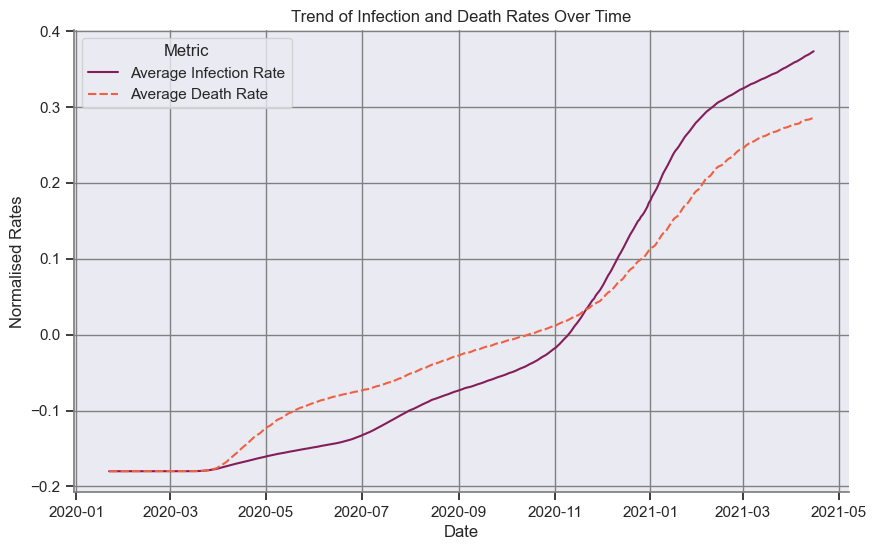

In [22]:
# Checking the range of dates
print("Date Range in Infection Data:", infection_data.index.min(), "to", infection_data.index.max())
print("Date Range in Mobility Data:", mobility_data.index.min(), "to", mobility_data.index.max())

# Plotting the trend of infection rates over time
infection_trend = infection_data.groupby(infection_data.index.date)['infection_rate'].mean()
death_trend = infection_data.groupby(infection_data.index.date)['death_rate'].mean()

# Convert the trends into a DataFrame for easier plotting 
trend_data = pd.DataFrame({
    'Date': infection_trend.index,
    'Average Infection Rate': infection_trend.values,
    'Average Death Rate': death_trend.values
}).melt(id_vars='Date', value_vars=['Average Infection Rate', 'Average Death Rate'],
        var_name='Metric', value_name='Rate')

# Ploting the graph
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_data, x='Date', y='Rate', hue='Metric', palette='rocket',style='Metric')

# Labels and Title
plt.xlabel('Date')
plt.ylabel('Normalised Rates')
plt.title('Trend of Infection and Death Rates Over Time')

# Show the plot
plt.show()


## Feature Correlation

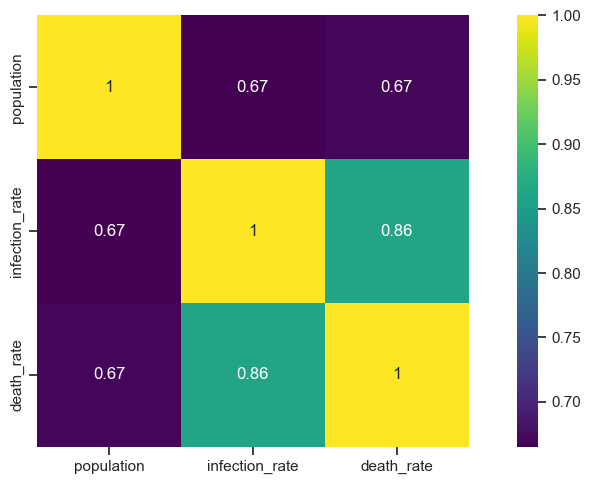

In [10]:
# Correlation matrix for infection data
# Selecting only numerical columns
infection_data_numeric = infection_data[['population', 'infection_rate', 'death_rate']]
correlation_matrix = infection_data_numeric.corr()

plt.figure(figsize=(10, 5))
# Plotting the heatmap with adjusted parameters
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', square=True)
# Use tight_layout to avoid clipping
plt.tight_layout()
# Show the plot
plt.show()


# Creating Graphs

In [11]:
# Extract, sort, and format unique dates
raw_dates = pd.to_datetime(mobility_data.index.date).normalize().drop_duplicates()
# Keeping only specified dates
end_of_2020 = pd.Timestamp('2020-12-31')
filtered_dates = raw_dates[raw_dates <= end_of_2020]
# Sort and format dates
dates = filtered_dates.sort_values().strftime('%Y-%m-%d').tolist()

In [26]:
# Creating graphs for everyday
def create_graph_for_day(date):
    # Get the data for the specific day
    infection_day = infection_data.loc[date]
    mobility_day = mobility_data.loc[date]
    
    # Create nodes (each county is a node)
    x = torch.tensor(infection_day[['population', 'death_rate', 'infection_rate']].values, dtype=torch.float)
    
    # Create edges
    edge_index = torch.tensor(mobility_day[['source', 'target']].values.T, dtype=torch.long)
    edge_attr = torch.tensor(mobility_day[['visitor_flows', 'distance_km']].values, dtype=torch.float)

    # Create graph
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    # Add target values
    y = torch.tensor(infection_day[['infection_rate']].values, dtype=torch.float).view(-1, 1)

    return graph, y


In [35]:
# Saving the graphs to file
def save_graphs_and_targets(dates, save_path):
    data_list = []
    targets_list = []
     # Creating graphs
    for date in dates:
        graph, target = create_graph_for_day(date)
        data_list.append(graph)
        targets_list.append(target)

    # Collate the graphs into a batch
    batch = Batch.from_data_list(data_list)

    # Stack targets into a single tensor
    targets = torch.stack(targets_list)

    # Save the processed data and targets to a file
    torch.save({'data': batch, 'targets': targets}, save_path)
    print(f"Saved graphs and targets to {save_path}")

save_path = r'D:\UoL\MSc Project\Dataset\graph_tensor\data.pt'
save_graphs_and_targets(dates, save_path)


Saved graphs and targets to D:\UoL\MSc Project\Dataset\graph_tensor\data.pt


In [12]:
# Loading the saved graphs
save_path = r'D:\UoL\MSc Project\Dataset\graph_tensor\data.pt'
def load_graphs_and_targets(load_path):
    # Load the saved dictionary
    saved_dict = torch.load(load_path)
    batch = saved_dict['data']
    targets = saved_dict['targets']
    return batch, targets

batch, targets = load_graphs_and_targets(save_path)
# Display the initial shapes
print("Batch shapes:")
print(f"Node features shape: {batch.x.shape}")
print(f"Edge index shape: {batch.edge_index.shape}")
print(f"Edge attributes shape: {batch.edge_attr.shape}")
print(f"Batch batch vector shape: {batch.batch.shape}")
print(f"Batch ptr shape: {batch.ptr.shape}")
print(f"Targets shape: {targets.shape}")

Batch shapes:
Node features shape: torch.Size([1150920, 3])
Edge index shape: torch.Size([2, 3728357])
Edge attributes shape: torch.Size([3728357, 2])
Batch batch vector shape: torch.Size([1150920])
Batch ptr shape: torch.Size([346])
Targets shape: torch.Size([345, 3336, 1])


# Graph Visualisation

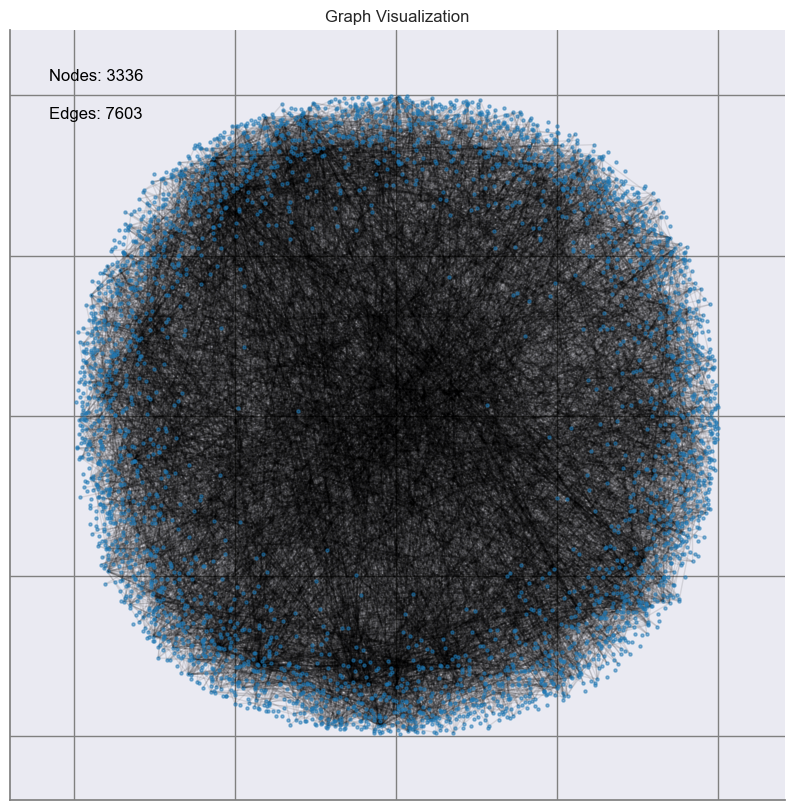

In [28]:
# Visualising a graph structure
def visualize_graph(graph):

    # Convert to NetworkX graph
    G = nx.Graph()
    
    # Add nodes with features
    for i in range(graph.x.size(0)):
        G.add_node(i, feature=graph.x[i].tolist())
    
    # Add edges with attributes
    edge_index = graph.edge_index.cpu().numpy()
    edge_attr = graph.edge_attr.cpu().numpy() if graph.edge_attr is not None else None
    
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        if edge_attr is not None:
            # Use only the first attribute if multiple attributes are present
            weight = edge_attr[i, 0]  
        else:
            weight = None
        G.add_edge(src, dst, weight=weight)
    
    # Plot the graph
    pos = nx.spring_layout(G, seed=42)  # Choose layout
    plt.figure(figsize=(10, 10))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=5, alpha=0.5, cmap='viridis')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.1, edge_color='black')
    
    # Display the number of nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    plt.text(0.05, 0.95, f'Nodes: {num_nodes}', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, color='black')
    plt.text(0.05, 0.90, f'Edges: {num_edges}', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, color='black')

    plt.title('Graph Visualization')
    plt.show()

graph, y = create_graph_for_day('2020-12-31')  
visualize_graph(graph)


# Data Loading

In [17]:
# Convert targets to have shape [num_nodes] for each graph
def adjust_target_shape(targets):
    return [target.squeeze(-1) for target in targets]

# Process the entire batch
def process_batch(batch, targets):
    data_list = []
    targets_list = adjust_target_shape(targets)
    
    for i in range(batch.num_graphs):
        start, end = batch.ptr[i], batch.ptr[i + 1]
        
        # Filter edges that belong to the current graph
        edge_mask = (batch.batch[batch.edge_index[0]] == i)
        
        data = Data(
            x=batch.x[start:end], 
            edge_index=batch.edge_index[:, edge_mask] - start,  # subtract start to re-index
            edge_attr=batch.edge_attr[edge_mask]
        )
        
        data_list.append(data)
    
    return data_list, targets_list


# Load the batch and targets
batch, targets = load_graphs_and_targets(save_path)

# Process the batch into a list of Data objects
data_list, targets_list = process_batch(batch, targets)

# Verify DataLoader output
for idx, (data, target) in enumerate(zip(data_list, targets_list)):
    print(f"Node features shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"Edge attributes shape: {data.edge_attr.shape}")
    print(f"Target shape: {targets[0].shape}")
    break


Node features shape: torch.Size([3336, 3])
Edge index shape: torch.Size([2, 10974])
Edge attributes shape: torch.Size([10974, 2])
Target shape: torch.Size([3336, 1])


# GCN Model Architecture

In [13]:
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels, dropout_rate=0.5):
        super(GNN, self).__init__()
        
        # First GCN Layer
        self.conv1 = GCNConv(in_channels, hidden_channels1)
        self.batch_norm1 = BatchNorm(hidden_channels1)
        
        # Second GCN Layer (new layer added)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.batch_norm2 = BatchNorm(hidden_channels2)
        
        # Third GCN Layer
        self.conv3 = GCNConv(hidden_channels2, out_channels)
        self.batch_norm3 = BatchNorm(out_channels)
        
        # Activation function and Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First GCN layer + BatchNorm + ReLU + Dropout
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second GCN layer + BatchNorm
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Third GCN layer + BatchNorm
        x = self.conv3(x, edge_index)
        x = self.batch_norm3(x)
        
        # Output shape should be [num_nodes, out_channels]
        return x
    
gcn_model = GNN(in_channels=3, hidden_channels1=64, hidden_channels2=32, out_channels=1)
print(gcn_model)


GNN(
  (conv1): GCNConv(3, 64)
  (batch_norm1): BatchNorm(64)
  (conv2): GCNConv(64, 32)
  (batch_norm2): BatchNorm(32)
  (conv3): GCNConv(32, 1)
  (batch_norm3): BatchNorm(1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


## Train and Vaidation 

In [5]:
# Initialize lists to store metrics
train_losses = []
val_losses = []

# Model training definition
def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    
    for data, target in train_loader:
        optimizer.zero_grad()
        # Forward pass
        out = model(data)
        # Reshape target to match the output shape
        target = target.view(-1, 1)  # Change target shape to [num_nodes, 1] 
        # Compute loss
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        # Store the loss 
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    return avg_train_loss

# Model validation definition
def validate(model, criterion, val_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, target in val_loader:
            # Forward pass
            out = model(data)
            # Reshape target to match the output shape
            target = target.view(-1, 1)  # Change target shape to [num_nodes, 1] 
            # Compute loss
            loss = criterion(out, target)
            # Store the loss
            total_loss += loss.item()
    
    avg_val_loss = total_loss / len(val_loader)
    return avg_val_loss

## Initialise the Model

In [15]:
# Initialize model and optimizer
gcn_model = GNN(in_channels=3, hidden_channels1=64, hidden_channels2=32, out_channels=1)
optimizer = optim.AdamW(gcn_model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.MSELoss()

# Walk-forward validation parameters
num_epochs = 5  # Number of epochs per validation step
initial_window_size = 70  # Number of initial time steps to start with
validation_step_size = 10  # Number of time steps to move forward for each iteration

## Training Loop with Walk Forward Validation

In [24]:
# Creating train and val windows
test_ratio = 0.1
total_length = len(data_list)
test_length = int(total_length * test_ratio)
train_val_length = total_length - test_length

# Split data and targets into train+validation and test sets
train_val_data = data_list[:train_val_length]
train_val_targets = targets_list[:train_val_length]
test_data = data_list[train_val_length:]
test_targets = targets_list[train_val_length:]


In [12]:
# Walk Forward Validation definition
def walk_forward_validation(train_val_data, train_val_targets, batch_size=16):
    total_length = len(train_val_data)
    
    if initial_window_size >= total_length:
        raise ValueError("Initial window size must be less than the total number of samples.")
    
    # Lists to store losses for each window
    window_indices = []
    avg_train_losses = []
    avg_val_losses = []
    
    # Iterate over each window step
    start = 0
    while start + initial_window_size < total_length:
        end = start + initial_window_size
        
        # Create training and validation sets for this step
        train_data = train_val_data[start:end]
        train_targets = train_val_targets[start:end]
        val_data = [train_val_data[end]]
        val_targets = [train_val_targets[end]]
        
        # Create DataLoaders
        train_loader = DataLoader(list(zip(train_data, train_targets)), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(list(zip(val_data, val_targets)), batch_size=1, shuffle=False)
        
        # Initialize metrics for the current window
        total_train_loss = 0.0
        total_val_loss = 0.0
        
        # Initialize timer for the window
        window_start_time = time.time()

        # Train and validate the model
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            
            # Training phase
            train_loss = train(gcn_model, optimizer, criterion, train_loader)
            total_train_loss += train_loss
            
            # Validation phase
            val_loss = validate(gcn_model, criterion, val_loader)
            total_val_loss += val_loss

            epoch_time = time.time() - epoch_start_time
            
            # Debug - Print metrics for each epoch
            # print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.2f} seconds')

        avg_train_loss = total_train_loss / num_epochs
        avg_val_loss = total_val_loss / num_epochs
        window_time = time.time() - window_start_time
        
        # Store losses and window index
        window_indices.append(f'{start+1}-{end}')
        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)
        
        # Print metrics for the current window
        print(f'Window {start+1}-{end} | Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f} | Time: {window_time:.2f} seconds')
        
        # Move the window forward
        start += validation_step_size
    
    return window_indices, avg_train_losses, avg_val_losses

window_indices, avg_train_losses, avg_val_losses = walk_forward_validation(train_val_data, train_val_targets, batch_size=16)


Window 1-70 | Avg Train Loss: 1.0042 | Avg Val Loss: 0.0255 | Time: 5.31 seconds
Window 11-80 | Avg Train Loss: 0.9478 | Avg Val Loss: 0.0238 | Time: 6.34 seconds
Window 21-90 | Avg Train Loss: 0.8894 | Avg Val Loss: 0.0248 | Time: 7.16 seconds
Window 31-100 | Avg Train Loss: 0.8472 | Avg Val Loss: 0.0232 | Time: 6.83 seconds
Window 41-110 | Avg Train Loss: 0.8023 | Avg Val Loss: 0.0252 | Time: 6.62 seconds
Window 51-120 | Avg Train Loss: 0.7616 | Avg Val Loss: 0.0287 | Time: 6.38 seconds
Window 61-130 | Avg Train Loss: 0.7233 | Avg Val Loss: 0.0332 | Time: 6.67 seconds
Window 71-140 | Avg Train Loss: 0.6823 | Avg Val Loss: 0.0374 | Time: 6.84 seconds
Window 81-150 | Avg Train Loss: 0.6553 | Avg Val Loss: 0.0433 | Time: 7.10 seconds
Window 91-160 | Avg Train Loss: 0.6152 | Avg Val Loss: 0.0548 | Time: 7.47 seconds
Window 101-170 | Avg Train Loss: 0.5900 | Avg Val Loss: 0.0744 | Time: 7.68 seconds
Window 111-180 | Avg Train Loss: 0.5663 | Avg Val Loss: 0.1040 | Time: 7.97 seconds
Window

## Learning Curve

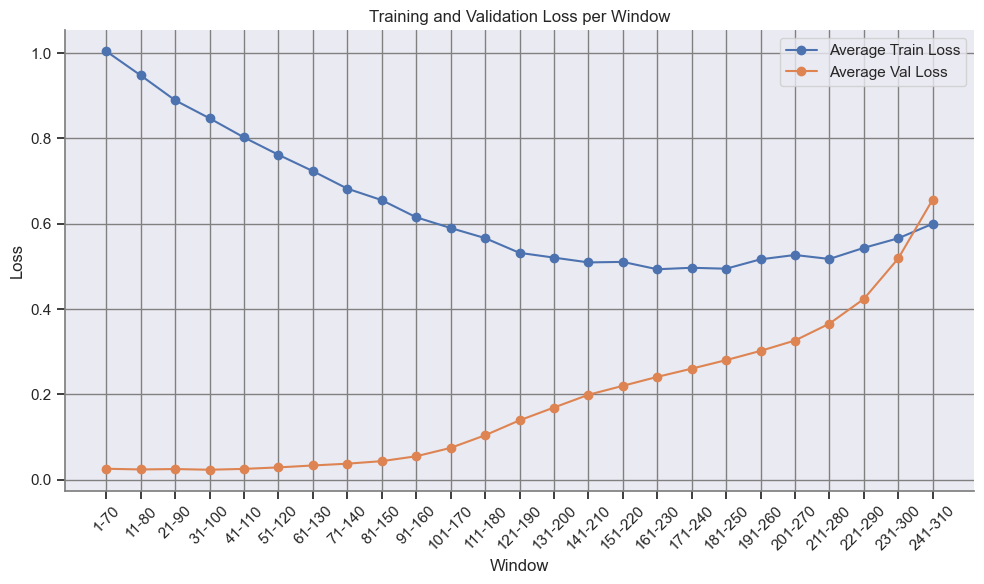

In [13]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(window_indices, avg_train_losses, marker='o', label='Average Train Loss')
plt.plot(window_indices, avg_val_losses, marker='o', label='Average Val Loss')
plt.xlabel('Window')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Window')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Saving and Loading the Model

In [21]:
# Specify the path  to save the model
path = r'D:\UoL\MSc Project\Code\Model\gcn_model_wf.pth'
# Save the model state dictionary
torch.save(gcn_model.state_dict(), path)
print(f"Model saved to {path}")

Model saved to D:\UoL\MSc Project\Code\Model\gcn_model_wf.pth


In [25]:
# Load the model state dictionary from path
path = r'D:\UoL\MSc Project\Code\Model\gcn_model_wf.pth'
gcn_model.load_state_dict(torch.load(path))
print(f"Model loaded from {path}")

Model loaded from D:\UoL\MSc Project\Code\Model\gcn_model_wf.pth


## Testing 

In [26]:
# Evaluate on the test set after completing walk-forward validation
gcn_model.eval()
with torch.no_grad():
    test_loader = DataLoader(list(zip(test_data, test_targets)), batch_size=1, shuffle=False)
    test_loss = 0.0
    all_targets = []
    all_outputs = []
    for data, target in test_loader:
        output = gcn_model(data)
        target = target.view(-1, 1)  # Change target shape to [num_nodes, 1]
        loss = criterion(output, target)
        test_loss += loss.item()
        # Store targets and outputs for further analysis
        all_targets.append(target.cpu().numpy())
        all_outputs.append(output.cpu().numpy())
    avg_test_loss = test_loss / len(test_loader)
    
     # Concatenate all targets and outputs for overall metrics
    all_targets = np.concatenate(all_targets)
    all_outputs = np.concatenate(all_outputs)

    # Calculate additional metrics
    mse = mean_squared_error(all_targets, all_outputs)
    mae = mean_absolute_error(all_targets, all_outputs)

    print(f"Test Loss: {avg_test_loss:.4f} - MSE: {mse:.4f} - MAE: {mae:.4f}")

Test Loss: 1.1185 - MSE: 1.1185 - MAE: 0.2784


* **MSE** (Mean Squared Error) of 1.0987: This is the average squared difference between predicted and actual values. Squaring the errors means that larger errors are penalized more heavily.
* **MAE** (Mean Absolute Error) of 0.2738: This is the average absolute difference between predicted and actual values.It's more interpretable because it is in the same units as the target variable.

## Predicted Results

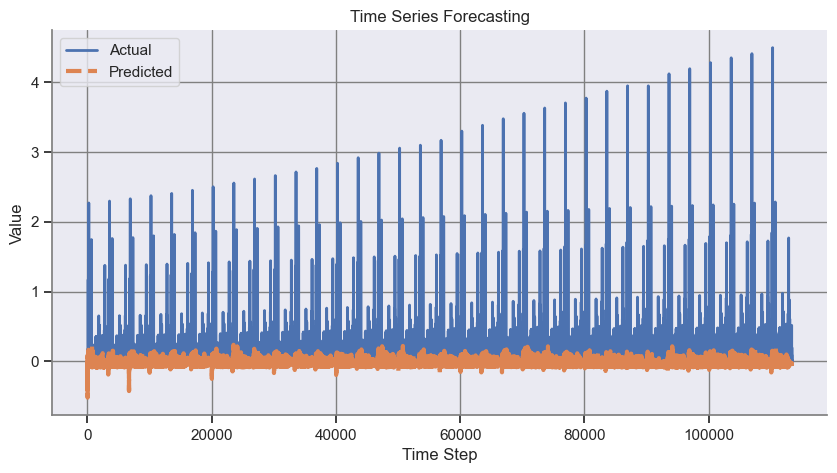

In [32]:
# Visualising time series forecasting results
def plot_forecasting_results(all_targets, all_outputs):
    # Convert arrays to pandas DataFrame for easier plotting
    time_steps = np.arange(len(all_targets))
    df = pd.DataFrame({
        'Time': time_steps,
        'Actual': all_targets.flatten(),
        'Predicted': all_outputs.flatten()
    })

    # Create a time series plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x='Time', y='Actual', label='Actual',  linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='Time', y='Predicted', label='Predicted', linestyle='--', linewidth=3)

    # Plotting formatting
    plt.title('Time Series Forecasting')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_forecasting_results(np.array(all_targets), np.array(all_outputs))

